## _*H2 excited states*_

This notebook demonstrates using Qiskit Nature to compute and plot graphs of excited state energies of the Hydrogen (H2) molecule over a range of inter-atomic distances. 
This notebook has been written to use the PYSCF chemistry driver.

In [12]:
import numpy as np
import pylab

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule, ExcitedStatesEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

from qiskit_algorithms import NumPyEigensolver
from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms import VQE

from qiskit.primitives import Estimator

We calculate the first 4 energy levels at 0.735A and compare the results from NumPyEigensolver and QEOM

In [13]:
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto3g")
molecule = driver.run()

mapper = ParityMapper(num_particles=molecule.num_particles)

In [14]:
def filter_criterion(eigenstate, eigenvalue, aux_values): # see the explanation for this here: https://qiskit-community.github.io/qiskit-nature/tutorials/04_excited_states_solvers.html
    return np.isclose(aux_values["ParticleNumber"][0], 2.0) and np.isclose(
        aux_values["Magnetization"][0], 0.0
    )

numpy_solver = NumPyEigensolver(k=4, filter_criterion=filter_criterion)

numpy_excited_states_solver = ExcitedStatesEigensolver(mapper, numpy_solver)
numpy_results = numpy_excited_states_solver.solve(molecule)

In [15]:
ansatz = UCCSD(
    molecule.num_spatial_orbitals,
    molecule.num_particles,
    mapper,
    initial_state=HartreeFock(
        molecule.num_spatial_orbitals,
        molecule.num_particles,
        mapper,
    ),
)

estimator = Estimator()
# This first part sets the ground state solver
solver = VQE(estimator, ansatz, SLSQP())
solver.initial_point = [0.0] * ansatz.num_parameters
gse = GroundStateEigensolver(mapper, solver)

qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)
qeom_results = qeom_excited_states_solver.solve(molecule)

/tmp/ipykernel_10328/3711651362.py:12: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [17]:
print(f'NumpyEigenSolver: {numpy_results.total_energies}')
print(f'QEOM: {qeom_results.total_energies}')
print(f'differences: {numpy_results.total_energies - qeom_results.total_energies}')

NumpyEigenSolver: [-1.13730604 -0.52461556 -0.16275316  0.49505774]
QEOM: [-1.13730604 -0.52461776 -0.16275536  0.49505554]
differences: [-5.76547698e-11  2.20534846e-06  2.20531847e-06  2.20532683e-06]


Now we plot the ground state and the first excited state over a range of interatomic distances

In [26]:
distances = np.linspace(0.5, 1.5, 15)

ground = np.zeros_like(distances)
first_excited = np.zeros_like(distances)

for i, d in enumerate(distances):
    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {d}", basis="sto3g")
    molecule = driver.run()
    mapper = ParityMapper(num_particles=molecule.num_particles)

    ansatz = UCCSD(
        molecule.num_spatial_orbitals,
        molecule.num_particles,
        mapper,
        initial_state=HartreeFock(
            molecule.num_spatial_orbitals,
            molecule.num_particles,
            mapper,
        ),
    )
    estimator = Estimator()
    solver = VQE(estimator, ansatz, SLSQP())
    solver.initial_point = [0.0] * ansatz.num_parameters
    gse = GroundStateEigensolver(mapper, solver)
    qeom_excited_states_solver = QEOM(gse, estimator, "s", EvaluationRule.ALL)
    qeom_results = qeom_excited_states_solver.solve(molecule)

    ground[i] = qeom_results.total_energies[0]
    first_excited[i] = qeom_results.total_energies[1]   

/tmp/ipykernel_10328/2915992211.py:21: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


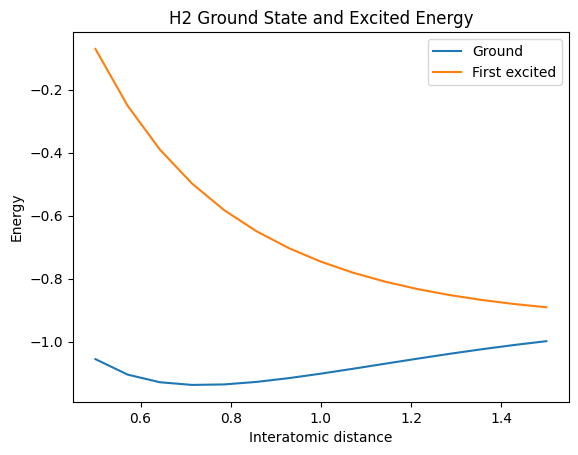

In [27]:
pylab.plot(distances, ground, label='Ground')
pylab.plot(distances, first_excited, label='First excited')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State and Excited Energy')
pylab.legend(loc='upper right')

In [25]:
! pip freeze | grep qiskit

qiskit==1.2.0
qiskit-aer==0.15.0
qiskit-algorithms==0.3.0
qiskit-ibm-runtime==0.31.0
qiskit-machine-learning==0.7.2
qiskit-nature==0.7.2
qiskit-nature-pyscf==0.4.0
qiskit-qasm3-import==0.5.0
qiskit-transpiler-service==0.4.5
